Price Prediction in the Real Estate Market

made by Enrique Barreiro Limón

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [2]:
housing_data = pd.read_csv("california_housing_train.csv", sep=",")
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.26,40.58,52.0,2217.0,394.0,907.0,369.0,2.3571,111400.0
16996,-124.27,40.69,36.0,2349.0,528.0,1194.0,465.0,2.5179,79000.0
16997,-124.30,41.84,17.0,2677.0,531.0,1244.0,456.0,3.0313,103600.0
16998,-124.30,41.80,19.0,2672.0,552.0,1298.0,478.0,1.9797,85800.0


Estadísticas descriptivas para todas las variables del dataframe.

In [3]:
# Obtenemos las estadísticas descriptivas de las variables numéricas en el DataFrame
descriptive_stats = housing_data.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.790000,-118.4900,-118.000,-114.3100
latitude,17000.0,35.625225,2.137340,32.5400,33.930000,34.2500,37.720,41.9500
housing_median_age,17000.0,28.589353,12.586937,1.0000,18.000000,29.0000,37.000,52.0000
total_rooms,17000.0,2643.664412,2179.947071,2.0000,1462.000000,2127.0000,3151.250,37937.0000
total_bedrooms,17000.0,539.410824,421.499452,1.0000,297.000000,434.0000,648.250,6445.0000
population,17000.0,1429.573941,1147.852959,3.0000,790.000000,1167.0000,1721.000,35682.0000
households,17000.0,501.221941,384.520841,1.0000,282.000000,409.0000,605.250,6082.0000
median_income,17000.0,3.883578,1.908157,0.4999,2.566375,3.5446,4.767,15.0001
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.000000,180400.0000,265000.000,500001.0000


In [4]:
# Identificamos automáticamente las variables categóricas
categorical_columns = [col for col in housing_data.columns if housing_data[col].dtype == 'object' or housing_data[col].nunique() < 10]

# Creamos un DataFrame vacío para almacenar las estadísticas descriptivas de las variables categóricas
categorical_stats = pd.DataFrame(columns=['unique_values', 'top', 'freq_top'])

# Verificamos si existen variables categóricas
if categorical_columns:
    # Calculamos estadísticas descriptivas para cada variable categórica
    for col in categorical_columns:
        unique_values = housing_data[col].nunique()  # Número de valores únicos
        top_value = housing_data[col].mode()[0]      # Valor más frecuente (moda)
        freq_top = housing_data[col].value_counts().iloc[0]  # Frecuencia del valor más frecuente

        # Añadimos los resultados al DataFrame
        categorical_stats.loc[col] = [unique_values, top_value, freq_top]

    # Mostramos el DataFrame con las estadísticas descriptivas de las variables categóricas
    print("Estadísticas descriptivas de variables categóricas:")
    print(categorical_stats)
else:
    print("No se identificaron variables categóricas.")

No se identificaron variables categóricas.


Búsqueda de valores faltantes.



In [5]:
# Calculamos la cantidad de valores faltantes para cada columna usando isna()
missing_values = housing_data.isna().sum()

# Creamos un DataFrame para mostrar los resultados
missing_values_df = pd.DataFrame(missing_values, columns=['missing_count'])
missing_values_df['missing_percentage'] = (missing_values_df['missing_count'] / len(housing_data)) * 100

# Mostramos el DataFrame con el conteo y porcentaje de valores faltantes
missing_values_df

,missing_count,missing_percentage
longitude,0,0.0
latitude,0,0.0
housing_median_age,0,0.0
total_rooms,0,0.0
total_bedrooms,0,0.0
population,0,0.0
households,0,0.0
median_income,0,0.0
median_house_value,0,0.0


# **Ejercicio - 1: Matriz de Correlación de Pearson**

### **1.1 Importancia del Coeficiente de Correlación de Pearson en el Análisis de Datos**

El coeficiente de correlación de Pearson, conocido también como coeficiente de correlación de Pearson, es fundamental en el análisis de datos, ya que cuantifica la fuerza y la dirección de la relación lineal entre dos variables. Este coeficiente varía entre -1 y +1, donde valores cercanos a +1 indican una fuerte correlación positiva, mientras que valores próximos a -1 sugieren una fuerte correlación negativa, y 0 que no hay relación lineal. Su aplicación abarca diversos campos, incluyendo las ciencias sociales y la educación, donde facilita la comprensión de las relaciones entre variables y la toma de decisiones informadas.

**Análisis Cuantitativo**
* **Medida Estandarizada:** Proporciona una medida estandarizada para evaluar relaciones entre datos de nivel intervalar o de razón, lo que facilita comparaciones entre estudios (Weisburd et al., 2019).
*  **Sensibilidad a Valores Atípicos:** El coeficiente es sensible a valores atípicos, que pueden distorsionar los resultados. Comprender esta sensibilidad es fundamental para interpretaciones precisas (Paranhos et al., 2014; Weisburd et al., 2019).
*  **Aplicaciones en Minería de Datos:** En contextos educativos, el coeficiente de Pearson puede emplearse para extraer reglas de asociación, mejorando los sistemas de evaluación docente (Hanyun & Shunfang, 2015).


**Consideraciones Metodológicas**
* **Desafíos de Interpretación:** Las correlaciones espurias, especialmente en análisis socioeconómicos, pueden generar interpretaciones erróneas, lo que exige enfoques metodológicos cuidadosos (Danacica, 2016).
* **Pruebas Estadísticas:** La significancia del coeficiente de Pearson puede evaluarse utilizando la distribución t, lo que proporciona un marco para validar los hallazgos (Weisburd et al., 2019).

Aunque el coeficiente de Pearson es una herramienta poderosa para analizar relaciones, es crucial considerar sus limitaciones y el contexto de los datos para evitar conclusiones erróneas. Métodos alternativos, como la correlación de rangos de Spearman, pueden ser más adecuados en casos con valores atípicos significativos o relaciones no lineales (Weisburd et al., 2019).


### **1.2 Aplicación y Limitaciones del Coeficiente de Correlación de Pearson**

El coeficiente de correlación de Pearson es aplicable principalmente a variables medidas en una escala de intervalo o de razón, lo que permite evaluar relaciones lineales entre dos variables continuas. Esta medida estadística se utiliza ampliamente en diversos campos, aunque su efectividad puede estar limitada bajo ciertas condiciones. A continuación, se detallan los tipos de variables adecuadas para el coeficiente de Pearson y sus limitaciones.

**Tipos de Variables**
* **Variables de Intervalo y Razón:** El coeficiente de Pearson está diseñado para datos continuos, específicamente en escalas de intervalo o de razón, donde la distancia entre los valores tiene un significado (Weisburd et al., 2019).

* **Variables Discretas:** Aunque puede aplicarse a variables discretas, los resultados pueden ser menos confiables si los datos no cumplen con los supuestos de normalidad y linealidad (Weisburd et al., 2019).

**Limitaciones**
* **Sensibilidad a los Valores Atípicos:** La correlación de Pearson es significativamente afectada por valores atípicos, lo que puede distorsionar el valor de la correlación y conducir a interpretaciones engañosas (Weisburd et al., 2019).

* **Relaciones No Lineales:** La correlación de Pearson tradicional puede no capturar adecuadamente las relaciones no lineales, lo que requiere métodos alternativos o técnicas mejoradas para una mayor precisión (Zhang et al., 2023).

En contraste, aunque la correlación de Pearson es una herramienta poderosa para relaciones lineales, puede no ser la mejor opción para todos los tipos de datos, especialmente cuando se trata de relaciones no lineales o en presencia de valores atípicos. Métodos alternativos, como la correlación por rangos de Spearman, pueden ofrecer perspectivas más robustas en tales casos (Weisburd et al., 2019).

### **1.3 Matriz de Correlación con Heatmap**

Despliega la matriz de correlación de las variables del dataframe "housing_data", incluyendo en cada celda de la matriz el valor numérico de la correlación entre cada par de variables. Al desplegar la matriz de correlación deberás además usar la opción del mapa de calor (heatmap) de la librería seaborn, usando el mapa de color 'BuGn'.

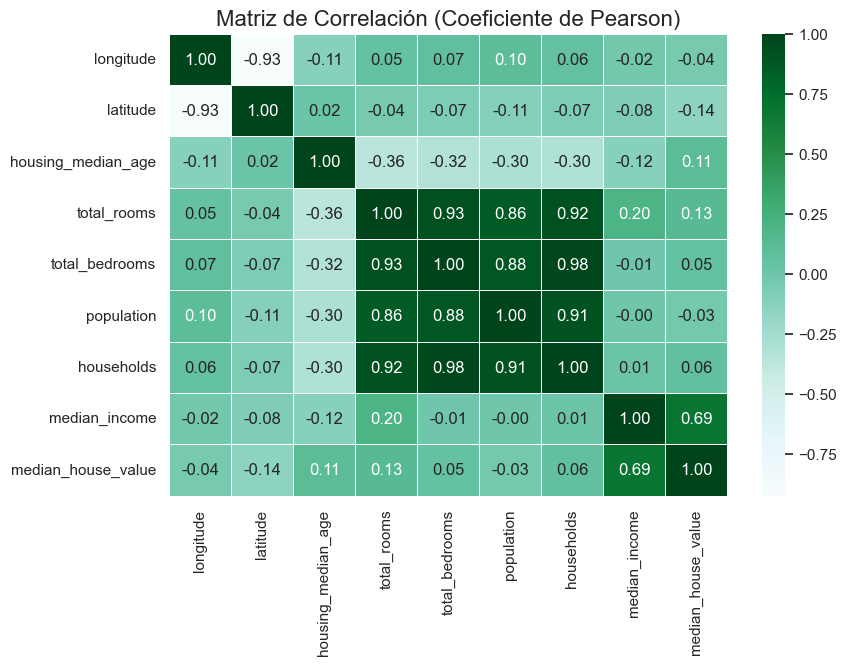

In [13]:
sns.set(rc={'figure.figsize':(9,6)})

# Calculamos la matriz de correlación usando el coeficiente de Pearson
correlation_matrix = housing_data.corr(method='pearson')

# Configuramos el heatmap con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='BuGn', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación (Coeficiente de Pearson)", fontsize=16)

# TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
plt.show()

El mapa de calor muestra la correlación entre todas las variables numéricas en el conjunto de datos. El valor de la correlación va de -1 a 1:

* 1 indica una correlación positiva perfecta (cuando una variable aumenta, la otra también lo hace).
* -1 indica una correlación negativa perfecta (cuando una variable aumenta, la otra disminuye).
* 0 significa que no hay correlación.

A continuación, analizamos los aspectos más importantes del mapa de calor.

### **Puntos Destacados del Heatmap**

**Correlaciones Altas Positivas:**
* **total_rooms y total_bedrooms (0.93):** Existe una relación lineal positiva muy fuerte entre el número de habitaciones totales y el número de dormitorios. Esto es lógico, ya que más habitaciones generalmente implican más dormitorios.
* **total_bedrooms y households (0.98):** Hay una correlación extremadamente alta, lo que indica que el número de dormitorios se asocia directamente con la cantidad de hogares. Es consistente, ya que más hogares suelen requerir más dormitorios.
* **median_income y median_house_value (0.69):** Una correlación positiva significativa, lo que sugiere que un mayor ingreso mediano está asociado con valores medianos de vivienda más altos.

**Correlaciones Altas Negativas:**
* **longitude y latitude (-0.93):** Existe una fuerte correlación negativa entre estas variables geográficas, lo que probablemente refleja la distribución espacial de las viviendas en el conjunto de datos de California.

**Correlaciones Moderadas:**
* **population y total_rooms (0.86):** Indica que las áreas con mayor población tienden a tener más habitaciones totales, lo cual es lógico en regiones densamente pobladas.
* **households y total_rooms (0.92):** Refleja que un mayor número de hogares se asocia con un mayor número de habitaciones.

**Correlaciones Débiles:**
* **housing_median_age y median_house_value (0.11):** Hay una relación muy débil, lo que sugiere que la edad de las viviendas no tiene un impacto significativo en el valor mediano de la vivienda.
* **population y median_house_value (-0.03):** Esto sugiere que la población no está estrechamente relacionada con los valores medianos de las viviendas.


### **Interpretación Relevante para Toma de Decisiones**

* **Factores Clave para el Valor de la Vivienda (median_house_value):** El ingreso mediano (median_income) es el factor más influyente (0.69). Esto resalta que áreas con ingresos más altos suelen tener viviendas más caras. Otras variables, como la cantidad de habitaciones (total_rooms, total_bedrooms) o la población, tienen una correlación débil, lo que indica que no son determinantes clave para el valor de las viviendas.

* **Relaciones Geográficas:** La correlación entre longitude y latitude refleja la disposición geográfica de las viviendas en el estado. Esto podría ser útil para análisis espaciales.
* **Planificación Urbana:** La relación entre households y total_rooms indica que áreas con más hogares tienden a requerir más infraestructura en términos de habitaciones, lo que es crucial para la planificación.

**Limitaciones del Análisis**

El coeficiente de Pearson mide solo relaciones lineales, por lo que podría no capturar relaciones no lineales entre las variables. Las correlaciones altas entre variables podrían implicar multicolinealidad, lo cual deberá manejarse cuidadosamente en el uso de modelos predictivos.

**Multicolinealidad**

La multicolinealidad en regresión es una condición que ocurre cuando algunas variables predictoras están fuertemente correlacionadas entre sí, de tal manera que si se incluyen simultáneamente en un modelo, impiden explicar de manera correcta el efecto que cada una tiene sobre la variable respuesta. Existen muchas formas de analizar si hay colinealidad en los modelos, una de ellas es el alto coeficiente de correlación entre variables.

# **Ejercicio - 2: Transformaciones e Histogramas de variables**

**INSTRUCCIONES:**

En este ejercicio se trabajará solamente con las siguientes 7 variables:

*   housing_median_age
*   total_rooms
*   total_bedrooms
*   population
*   households
*   median_income
*   median_house_value

A cada una de dichas variables les deberás aplicar las siguientes transformaciones y desplegar sus histogramas con 20 barras (bins):

*   Raíz cuadrada con Numpy.
*   Logaritmo natural con Numpy.
*   Potencia 2 (i.e., elevar al cuadrado) con Numpy.
*   Investiga y aplica Box-Cox con scikit-learn.

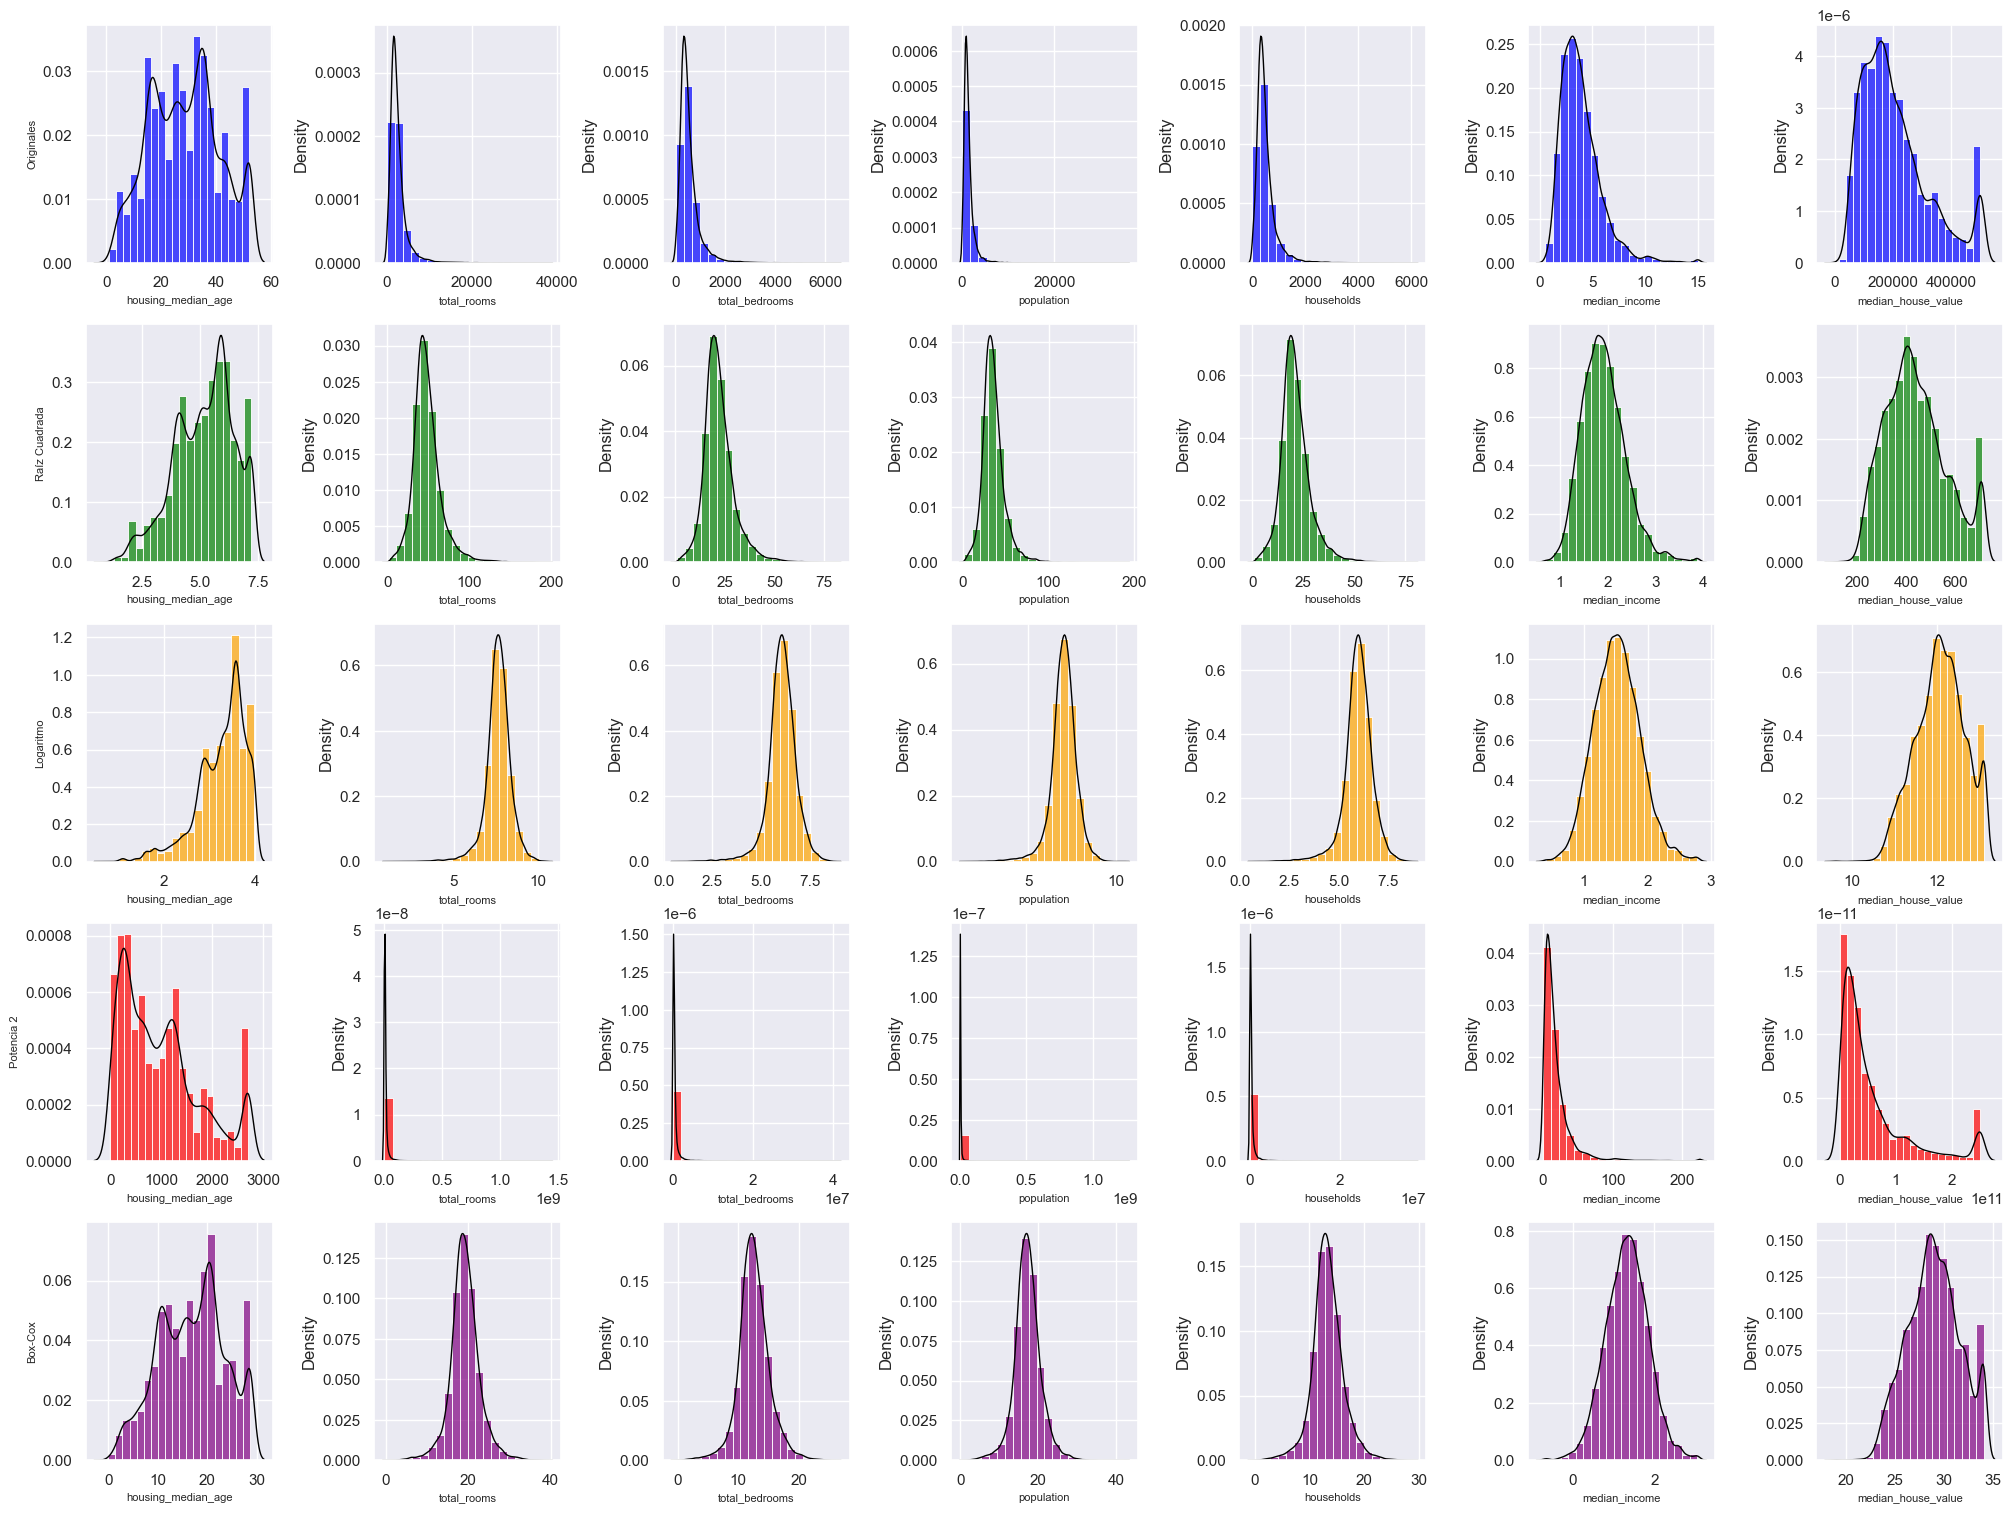

In [7]:
from sklearn.preprocessing import PowerTransformer

# Lista de las variables a trabajar
variables_a_transformar = ['housing_median_age', 'total_rooms', 'total_bedrooms',
                           'population', 'households', 'median_income', 'median_house_value']

sns.set(rc={'figure.figsize': (20, 15)})
fig, axes = plt.subplots(5, 7)

# Inicializamos el transformador Box-Cox
pt = PowerTransformer(method='box-cox', standardize=False)

for k in range(0, 7):
    # Datos originales ---------------------------------------------------------
    plt.subplot(5, 7, k + 1)

    Transf0 = housing_data[variables_a_transformar[k]]  # Valores originales sin transformar
    sns.histplot(Transf0, bins=20, color='blue', alpha=0.7, stat="density")  # Histograma
    sns.kdeplot(Transf0, color='black', linewidth=1, ax=plt.gca())  # KDE

    plt.xlabel(variables_a_transformar[k], fontsize=8) 
    if k == 0:
        plt.ylabel('Originales', fontsize=8)

    # Datos transformados con raíz cuadrada ------------------------------------
    plt.subplot(5, 7, k + 8)

    Transf1 = np.sqrt(housing_data[variables_a_transformar[k]])  # Raíz cuadrada
    sns.histplot(Transf1, bins=20, color='green', alpha=0.7, stat="density")  # Histograma
    sns.kdeplot(Transf1, color='black', linewidth=1, ax=plt.gca())  # KDE

    plt.xlabel(variables_a_transformar[k], fontsize=8)
    if k == 0:
        plt.ylabel('Raíz Cuadrada', fontsize=8)

    # Datos transformados con logaritmo natural --------------------------------
    plt.subplot(5, 7, k + 15)

    Transf2 = np.log1p(housing_data[variables_a_transformar[k]])  # Logaritmo natural
    sns.histplot(Transf2, bins=20, color='orange', alpha=0.7, stat="density")  # Histograma
    sns.kdeplot(Transf2, color='black', linewidth=1, ax=plt.gca())  # KDE

    plt.xlabel(variables_a_transformar[k], fontsize=8)
    if k == 0:
        plt.ylabel('Logaritmo', fontsize=8)

    # Datos transformados con la potencia de 2 ---------------------------------
    plt.subplot(5, 7, k + 22)

    Transf3 = np.power(housing_data[variables_a_transformar[k]], 2)  # Potencia al cuadrado
    sns.histplot(Transf3, bins=20, color='red', alpha=0.7, stat="density")  # Histograma
    sns.kdeplot(Transf3, color='black', linewidth=1, ax=plt.gca())  # KDE

    plt.xlabel(variables_a_transformar[k], fontsize=8)
    if k == 0:
        plt.ylabel('Potencia 2', fontsize=8)

    # Datos transformados con Box-Cox ------------------------------------------
    plt.subplot(5, 7, k + 29)

    if (housing_data[variables_a_transformar[k]] > 0).all():  # Verificamos si todos los valores son positivos
        Transf4 = pt.fit_transform(housing_data[variables_a_transformar[k]].values.reshape(-1, 1))
        sns.histplot(Transf4.flatten(), bins=20, color='purple', alpha=0.7, stat="density")  # Histograma
        sns.kdeplot(Transf4.flatten(), color='black', linewidth=1, ax=plt.gca())  # KDE
    else:
        plt.text(0.5, 0.5, 'No aplica', ha='center', va='center', transform=plt.gca().transAxes, fontsize=8)
        plt.axis('off')  # Ocultamos el gráfico si Box-Cox no es aplicable

    plt.xlabel(variables_a_transformar[k], fontsize=8)
    if k == 0:
        plt.ylabel('Box-Cox', fontsize=8)

# Ajustamos el espaciado entre gráficos
plt.tight_layout(pad=0.2)  # Mayor separación general
plt.show()

# **Ejercicio - 3 - Métricas de desempeño: $RMSE$, $MAE$ y $MAPE$**


El Error Cuadrático Medio (RMSE), el Error Absoluto Medio (MAE) y el Error Absoluto Medio Porcentual (MAPE) son métricas comunes utilizadas para evaluar la precisión de los modelos predictivos. Cada métrica tiene sus fortalezas y debilidades, y su aplicabilidad depende de la distribución de los errores y del contexto específico de la evaluación del modelo. El RMSE es particularmente sensible a errores grandes, lo que lo hace adecuado para errores con distribución normal, mientras que el MAE es más robusto frente a valores atípicos y es óptimo para distribuciones de error Laplacianas. Por otro lado, el MAPE proporciona un error en forma de porcentaje, lo cual puede ser útil para entender el tamaño relativo de los errores. A continuación, se presenta una exploración detallada de estas métricas.

### **$RMSE$** (Root Mean Squared Error):

* El RMSE se calcula como la raíz cuadrada del promedio de las diferencias al cuadrado entre los valores predichos y observados.
* Es sensible a errores grandes debido al proceso de elevar al cuadrado las diferencias, lo que puede ser beneficioso cuando los errores grandes son particularmente indeseables.
* El RMSE es óptimo para errores con distribución normal (Gaussiana), ya que penaliza más severamente las desviaciones mayores (Hodson, 2022) ("Comment on gmd-2022-64", 2022) (Mantovani, 2022).

**Fórmula:**

$$
RMSE = RMS = \sqrt{MSE} = \sqrt{\frac{SSE}{n}} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

**Definición de Variables**
- $y$: Valores observados reales.
- $\hat{y}$: Valores de predicción.
- $n$: Número total de observaciones (Train, Val o Test).

In [8]:
# Función para calcular el RMSE
def mi_RMSE(y, y_hat):
    return np.sqrt(np.mean(np.square(y - y_hat)))

# Se calcula el promedio del cuadrado de las diferencias, y luego se toma la raíz cuadrada.

### **$MAE$**  (Mean Absolute Error):

* El MAE es el promedio de las diferencias absolutas entre los valores predichos y observados.
* Proporciona una puntuación lineal que es menos sensible a los valores atípicos en comparación con el RMSE.
* El MAE es óptimo para distribuciones de error Laplacianas, donde los errores están distribuidos simétricamente alrededor de un punto central (Hodson, 2022) ("Comment on gmd-2022-64", 2022) (Mantovani, 2022).

**Fórmula:**
$$
MAE = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

**Definición de Variables**
- $y$: Valores observados reales.
- $\hat{y}$: Valores de predicción.
- $n$: Número total de observaciones (Train, Val o Test).

In [9]:
# Función para calcular el MAE
def mi_MAE(y, y_hat):
    return np.mean(np.abs(y - y_hat))

# Se calcula el promedio del valor absoluto de las diferencias.

### **$MAPE$** (Mean Absolute Percentage Error):

* El MAPE expresa el error como un porcentaje de los valores observados, lo que puede ser útil para entender el error en términos relativos.
* Es particularmente valioso cuando la escala de los datos es importante, pero puede ser problemático en casos de valores observados cercanos a cero o iguales a cero, lo que lleva a errores indefinidos o exagerados (Müller-Plath & Lüdecke, 2024).

**Fórmula:**

$$
MAPE = \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

**Definición de Variables**
- $y$: Valores observados reales.
- $\hat{y}$: Valores de predicción.
- $n$: Número total de observaciones (Train, Val o Test).

In [10]:
# Función para calcular el MAPE
def mi_MAPE(y, y_hat):
    return np.mean(np.abs((y - y_hat) / y)) * 100

# Calcula el promedio del valor absoluto del porcentaje del error, multiplicado por 100 para obtener el resultado en porcentaje.

Aunque el RMSE, MAE y MAPE son ampliamente utilizados, no son aplicables de manera universal. La elección entre RMSE y MAE a menudo depende de la distribución de los errores, y ninguno es intrínsecamente superior. El MAPE ofrece una perspectiva diferente al enfocarse en errores porcentuales, pero presenta limitaciones con denominadores pequeños. Por lo tanto, la selección de una métrica de error debe estar guiada por las características específicas de los datos y los objetivos del análisis.

In [11]:
Xtrain = housing_data.drop('median_house_value', axis='columns')
ytrain = housing_data['median_house_value']

num_prepro_pipeline = Pipeline(steps = [('imputar', SimpleImputer(strategy='median')),
                                        ('scalar', MinMaxScaler(feature_range=(1, 2))),
                                        ('sqrt', FunctionTransformer(np.sqrt))
                                        ])

numerical_features = ['total_rooms','total_bedrooms','population','households','median_income']

columnasTransformer = ColumnTransformer(transformers = [('numerical', num_prepro_pipeline, numerical_features)],
                                        remainder='passthrough')

modelo_LR = LinearRegression()

scores_RMSEVal = []
scores_MAEVal = []
scores_MAPEVal = []

kf = KFold(n_splits= 10, shuffle=True)

for train_index, val_index in kf.split(Xtrain):

  X_train, X_val = Xtrain.loc[train_index], Xtrain.loc[val_index]
  y_train, y_val = ytrain[train_index], ytrain[val_index]

  XtrainFit = columnasTransformer.fit(X_train)
  XtrainTransf = XtrainFit.transform(X_train)

  modelo_LR = modelo_LR.fit(XtrainTransf, y_train)


  XvalTransf = XtrainFit.transform(X_val)
  yhatVal = modelo_LR.predict(XvalTransf)

  scores_RMSEVal.append(mi_RMSE(y_val, yhatVal))
  scores_MAEVal.append(mi_MAE(y_val, yhatVal))
  scores_MAPEVal.append(mi_MAPE(y_val, yhatVal))


# Desplegar información:
results = [scores_RMSEVal, scores_MAEVal, scores_MAPEVal]
names = ['RMSEval','MAEval','MAPEval']

print("\t  %s\t\t%s   \t\t%s" % (names[0],names[1],names[2]))
for i,z in enumerate(zip(scores_RMSEVal, scores_MAEVal, scores_MAPEVal)):
  print("fold[%d]:  %.1f \t\t%.1f  \t\t%.1f%%" % (i+1,z[0],z[1],z[2]))
print("mean(std) %.1f(%.1f)  \t%.1f(%.1f)   \t%.1f%% (%.1f)" % (np.mean(scores_RMSEVal), np.std(scores_RMSEVal),
                                                                np.mean(scores_MAEVal), np.std(scores_MAEVal),
                                                                np.mean(scores_MAPEVal), np.std(scores_MAPEVal)))

	  RMSEval		MAEval   		MAPEval
fold[1]:  68247.3 		49039.6  		29.6%
fold[2]:  68154.0 		50881.2  		31.1%
fold[3]:  70691.7 		52095.9  		30.8%
fold[4]:  67214.2 		50352.1  		30.2%
fold[5]:  70402.7 		51612.1  		31.1%
fold[6]:  72467.2 		52102.6  		29.9%
fold[7]:  66743.1 		48998.8  		29.5%
fold[8]:  70157.8 		50636.5  		29.8%
fold[9]:  69064.2 		50843.4  		29.6%
fold[10]:  67528.5 		50384.5  		30.5%
mean(std) 69067.1(1728.6)  	50694.7(1033.3)   	30.2% (0.6)


### **$RMSE$** (Root Mean Squared Error):
- **Promedio (mean):** 69,067.1
- **Desviación estándar (std):** 1,728.6

**Interpretación:**
- El RMSE mide el promedio del error cuadrático de las predicciones. Valores altos indican un error absoluto mayor.
- El RMSE muestra cierta variabilidad entre los folds, pero la desviación estándar (1,728.6) es pequeña en relación con el promedio. Esto indica que el modelo es consistente  en su desempeño en los diferentes folds.


### **$MAE$** (Mean Absolute Error):
- **Promedio (mean):** 50,694.7
- **Desviación estándar (std):** 1,033.3

**Interpretación:**
- El MAE mide el error absoluto promedio de las predicciones, lo que da una mejor idea del error medio sin penalizar grandes desviaciones como el RMSE.
- Los valores del MAE son más bajos que los del RMSE, lo que es esperable, ya que el RMSE penaliza los errores grandes más severamente.
- La desviación estándar (1,033.3) es baja en comparación con el promedio, lo que refuerza la consistencia del modelo.


### **$MAPE$** (Mean Absolute Percentage Error)
- **Promedio (mean):** 30.2%
- **Desviación estándar (std):** 0.6%

**Interpretación:**
- El MAPE indica el error relativo promedio en porcentaje, lo que facilita la interpretación en términos relativos a la magnitud de los valores reales.
- Una variación del 0.6% entre los folds muestra que el modelo tiene un comportamiento muy estable respecto al porcentaje de error.
- El MAPE del 30.2% sugiere que, en promedio, las predicciones se desvían en un 30.2% de los valores reales. Esto puede considerarse moderadamente alto.

### **$RMSE$** vs **$MAE$**

El RMSE es más alto que el MAE, lo que sugiere que hay algunos valores atípicos o errores grandes que están afectando las predicciones, ya que el RMSE amplifica estos errores.


**\<\<Fin de la Actividad_1_Semana_2>>**